## Levy Stable models of Stochastic Volatility

This tutorial demonstrates inference using the Levy [Stable](http://docs.pyro.ai/en/stable/distributions.html#stable) distribution through a motivating example of a non-Gaussian stochastic volatilty model.

Inference with stable distribution is tricky because the density `Stable.log_prob()` is not defined. In this tutorial we demonstrate two approaches to inference: (i) using the [poutine.reparam](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) effect to transform models in to a tractable form, and (ii) using the likelihood-free loss [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance) with SVI.


#### Summary

- [Stable.log_prob()](http://docs.pyro.ai/en/stable/distributions.html#stable) is undefined.
- Stable inference requires either reparameterization or a likelihood-free loss.
- Reparameterization:
    - The [poutine.reparam()](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) handler can transform models using various [strategies](http://docs.pyro.ai/en/latest/infer.reparam.html).
    - The [StableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.StableReparam) strategy can be used for Stable distributions in SVI or HMC.
    - The [LatentStableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.LatentStableReparam) strategy is a little cheaper, but cannot be used for likelihoods.
    - The [DiscreteCosineReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.discrete_cosine.DiscreteCosine) strategy improves geometry in batched latent time series models.
- Likelihood-free loss with SVI:
    - The [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance) loss allows stable distributions in the guide and in model likelihoods.

#### Table of contents

- [Daily S&P data](#data)
- [Fitting a single distribution to log returns](#fitting) using `EnergyDistance`
- [Modeling stochastic volatility](#modeling) using `poutine.reparam`

## Daily S&P 500 data <a class="anchor" id="data"></a>

The following daily closing prices for the S&P 500 were loaded from [Yahoo finance](https://finance.yahoo.com/quote/%5EGSPC/history/).

In [1]:
import math
import os
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints

from pyro import poutine
from pyro.contrib.examples.finance import load_snp500
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.reparam import DiscreteCosineReparam, StableReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve

%matplotlib inline
assert pyro.__version__.startswith('1.1.0')
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)

In [2]:
df = load_snp500()
dates = df.Date.to_numpy()
x = torch.tensor(df["Close"]).float()
x.shape

torch.Size([23116])

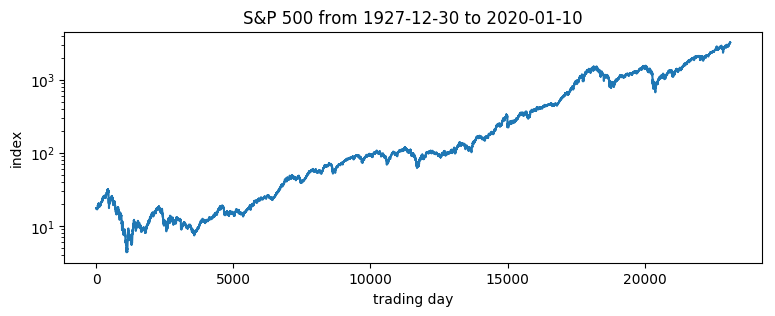

In [3]:
pyplot.figure(figsize=(9, 3))
pyplot.plot(x)
pyplot.yscale('log')
pyplot.ylabel("index")
pyplot.xlabel("trading day")
pyplot.title("S&P 500 from {} to {}".format(dates[0], dates[-1]));


Of interest are the log returns, i.e. the log ratio of price on two subsequent days.

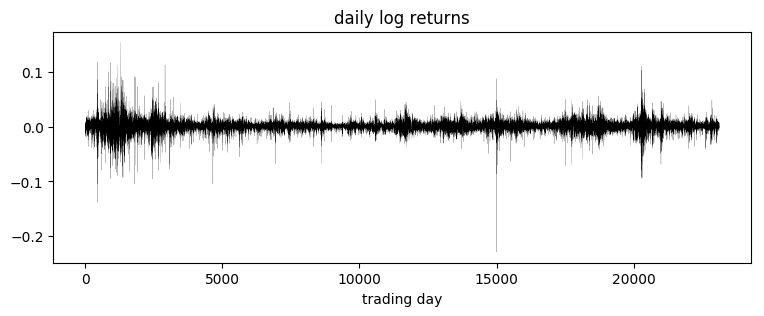

In [4]:
pyplot.figure(figsize=(9, 3))
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1)
pyplot.title("daily log returns")
pyplot.xlabel("trading day");

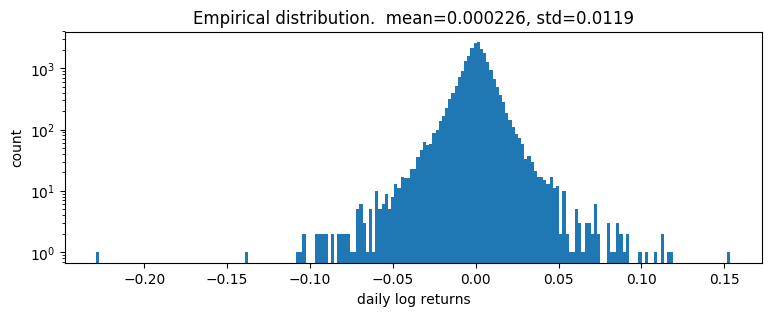

In [5]:
pyplot.figure(figsize=(9, 3))
pyplot.hist(r, bins=200)
pyplot.yscale('log')
pyplot.ylabel("count")
pyplot.xlabel("daily log returns")
pyplot.title("Empirical distribution.  mean={:0.3g}, std={:0.3g}".format(r.mean(), r.std()));

## Fitting a single distribution to log returns  <a class="anchor" id="fitting"></a>

Log returns appear to be heavy-tailed. First let's fit a single distribution to the returns. To fit the distribution, we'll use a likelihood free statistical inference algorithm [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance), which matches fractional moments of observed data and can handle data with heavy tails.

In [6]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = 0.
    scale = pyro.param("scale", torch.tensor(0.1), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 8.961664199829102
step 20 loss = 4.8506011962890625
step 40 loss = 1.5543489456176758
step 60 loss = 1.7787070274353027
step 80 loss = 1.4140945672988892
step 100 loss = 1.3671720027923584
step 120 loss = 1.287503719329834
step 140 loss = 1.2791334390640259
step 160 loss = 1.2810490131378174
step 180 loss = 1.2784368991851807
step 200 loss = 1.2823134660720825
loc = 0.0003696
scale = 0.00872
stability = 1.977
CPU times: user 14.6 s, sys: 673 ms, total: 15.3 s
Wall time: 2.48 s


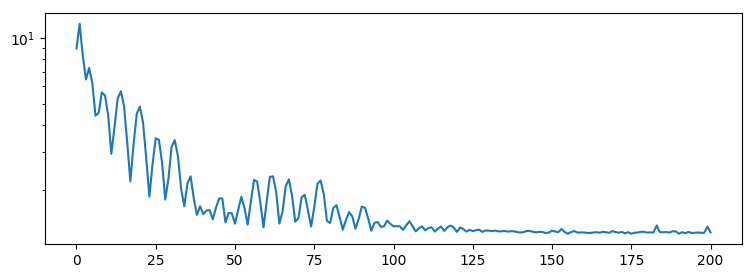

In [7]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1 if smoke_test else 201
optim = ClippedAdam({"lr": 0.1, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, EnergyDistance())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))

pyplot.figure(figsize=(9, 3))
pyplot.plot(losses)
pyplot.yscale('log')
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.squeeze().item()))

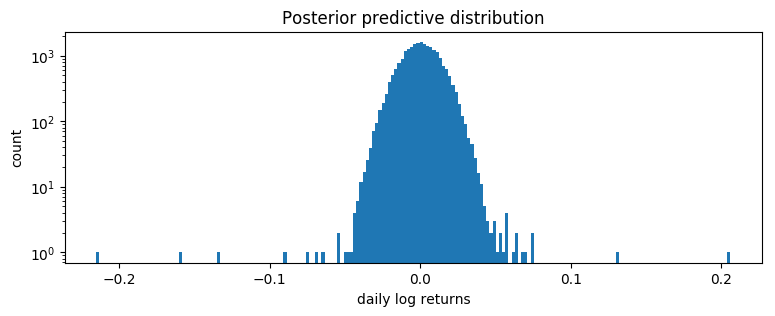

In [8]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(9, 3))
pyplot.hist(samples, bins=200)
pyplot.yscale("log")
pyplot.xlabel("daily log returns")
pyplot.ylabel("count")
pyplot.title("Posterior predictive distribution");


This is a poor fit, but that was to be expected since we are mixing all time steps together: we would expect this to be a scale-mixture of distributions (Normal, or Stable), but are modeling it as a single distribution (Stable in this case).

## Modeling stochastic volatility  <a class="anchor" id="modeling"></a>

Consider a stochastic volatity model of the log returns $r_t$ and a latent volatility $h$, where we assume $\log h$ follows damped brownian motion with location $-\delta/\phi$ and diffusion rate $\sigma$:
$$
  \log h_t = \delta + \phi \log h_{t-1} + \sigma v_t \\
  r_t = w_t \sqrt{h_t}
$$
Usually $\sigma v_1$ and $w_t$ are both Gaussian. We will generalize to a Stable distribution for $w_t$.

In [9]:
def model(data):
    # We model volatility as a Gaussian process, where h_noise are the independent increments.
    # Note we avoid plates because we'll later reparameterize along the time axis using
    # DiscreteCosineReparam, breaking independence. This requires .unsqueeze()ing scalars.
    h_scale = pyro.sample("h_scale", dist.LogNormal(0, 1)).unsqueeze(-1)
    h_loc = pyro.sample("h_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    h_noise = pyro.sample("h_noise", dist.Normal(0, 1).expand([len(data)]).to_event(1))
    log_h = pyro.deterministic("log_h", h_loc + h_scale * h_noise.cumsum(dim=-1))

    # Observed log returns, assumed to be a Stable distribution.
    r_scale = log_h.mul(0.5).exp().clamp(min=1e-8)
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    r_skew = pyro.sample("r_skew", dist.Uniform(-1, 1)).unsqueeze(-1)
    r_stability = pyro.sample("r_stability", dist.Uniform(1, 2)).unsqueeze(-1)
    pyro.sample("r", dist.Stable(r_stability, r_skew, r_scale, r_loc).to_event(1), obs=data)

We use two reparameterizers: [StableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.StableReparam) to handle the `Stable` likelihood (since `Stable.log_prob()` is undefined), and [DiscreteCosineReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.discrete_cosine.DiscreteCosineReparam) to improve geometry of the latent Gaussian process for `log_h`. We'll then use `reparam_model` for both inference and prediction.

In [10]:
reparam_model = poutine.reparam(model, {"h_noise": DiscreteCosineReparam(),
                                        "r": StableReparam()})

step 0 loss = 22.7854
step 50 loss = 9.02894
step 100 loss = 1.97595
step 150 loss = -1.28622
step 200 loss = -2.46754
step 250 loss = -2.59977
step 300 loss = -2.39353
step 350 loss = -2.945
step 400 loss = -2.67713
step 450 loss = -2.98859
step 500 loss = -3.01408
step 550 loss = -3.01569
step 600 loss = -3.06335
step 650 loss = -3.05235
step 700 loss = -3.06749
step 750 loss = -3.0808
step 800 loss = -3.07289
step 850 loss = -3.09997
step 900 loss = -3.077
step 950 loss = -3.08251
step 1000 loss = -3.08729
h_loc = -0.002584 ± 0.002107
h_scale = 0.1608 ± 0.0003581
r_loc = 0.0009197 ± 0.0001664
r_skew = 0.0004958 ± 0.0001981
r_stability = 1.958 ± 0.001281
CPU times: user 38.9 s, sys: 5.68 s, total: 44.5 s
Wall time: 44.6 s


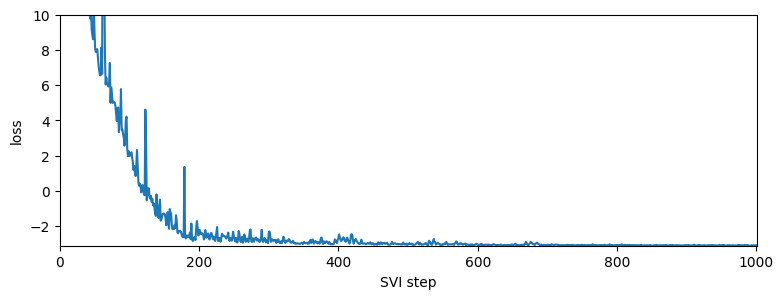

In [11]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1 if smoke_test else 1001
optim = ClippedAdam({"lr": 0.1,
                     "betas": (0.9, 0.99),
                     "lrd": 0.01 ** (1 / num_steps)})
guide = AutoDiagonalNormal(reparam_model, init_scale=0.01)
svi = SVI(reparam_model, guide, optim, Trace_ELBO())
losses = []
for step in range(num_steps):
    loss = svi.step(r) / len(r)
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        print("step {} loss = {:0.6g}".format(step, loss))

pyplot.figure(figsize=(9,3))
pyplot.plot(losses)
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
pyplot.xlim(0, len(losses))
pyplot.ylim(min(losses), 10)
for name, (lb, ub) in sorted(guide.quantiles([0.325, 0.675]).items()):
    if lb.numel() == 1:
        lb = lb.detach().squeeze().item()
        ub = ub.detach().squeeze().item()
        print("{} = {:0.4g} ± {:0.4g}".format(name, (lb + ub) / 2, (ub - lb) / 2))

It appears the log returns show very little skew, but show a stability parameter slightly but significantly less than 1. We can now visualize the estimated volatility:

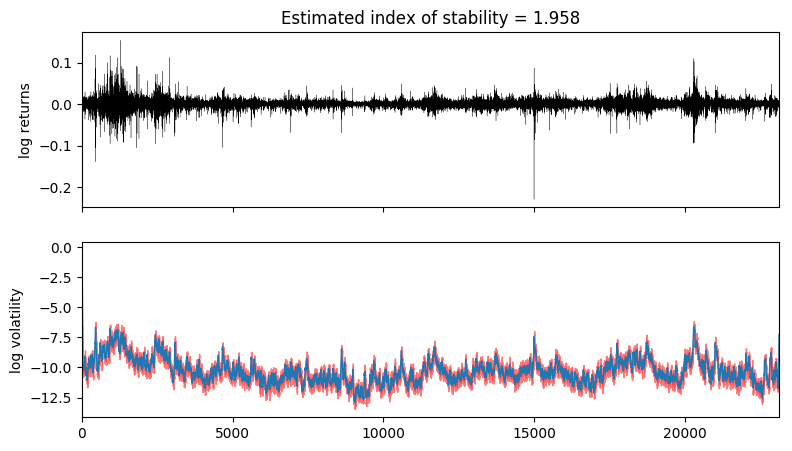

In [12]:
fig, axes = pyplot.subplots(2, figsize=(9, 5), sharex=True)
axes[0].plot(r, "k", lw=0.2)
axes[0].set_ylabel("log returns")
axes[0].set_xlim(0, len(r))

# We will pull out median log returns using the autoguide's .median() and poutines.
with torch.no_grad():
    pred = Predictive(reparam_model, guide=guide, num_samples=20, parallel=True)(r)
log_h = pred["log_h"]
axes[1].plot(log_h.median(0).values, lw=1)
axes[1].fill_between(torch.arange(len(log_h[0])),
                     log_h.kthvalue(2, dim=0).values,
                     log_h.kthvalue(18, dim=0).values,
                     color='red', alpha=0.5)
axes[1].set_ylabel("log volatility")

stability = pred["r_stability"].median(0).values.item()
axes[0].set_title("Estimated index of stability = {:0.4g}".format(stability));

Observe that volatility roughly follows areas of large absolute log returns. Note that the uncertainty is underestimated, since we have used an approximate `AutoDiagonalNormal` guide. For more precise uncertainty estimates, one could use [HMC](http://docs.pyro.ai/en/stable/mcmc.html#hmc) or [NUTS](http://docs.pyro.ai/en/stable/mcmc.html#nuts) inference.